##Implement Otsu’s thresholding, watershed algorithm and K Means.

In [3]:
!pip install opencv-python

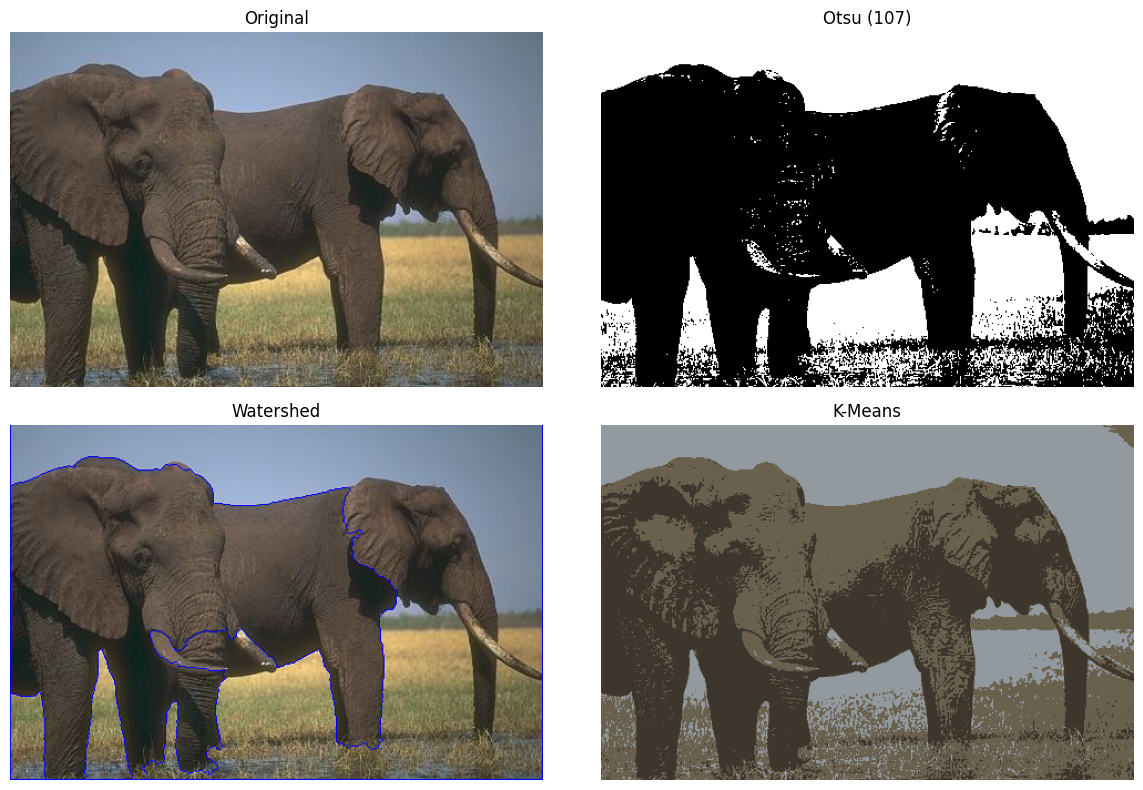

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
%matplotlib inline

url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/296059.jpg"
resp = urllib.request.urlopen(url)
data = np.asarray(bytearray(resp.read()), dtype=np.uint8)
image = cv2.imdecode(data, cv2.IMREAD_COLOR)
if image is None:
    raise RuntimeError("Failed to load image")

def otsu_threshold(image):
    hist = np.bincount(image.ravel(), minlength=256)
    total = image.size
    sum_total = (hist * np.arange(256)).sum()
    sum_back = 0
    weight_back = 0
    max_var = 0
    threshold = 0
    for i in range(256):
        weight_back += hist[i]
        if weight_back == 0:
            continue
        weight_fore = total - weight_back
        if weight_fore == 0:
            break
        sum_back += i * hist[i]
        mean_back = sum_back / weight_back
        mean_fore = (sum_total - sum_back) / weight_fore
        var_between = weight_back * weight_fore * (mean_back - mean_fore)**2
        if var_between > max_var:
            max_var = var_between
            threshold = i
    binary_image = (image > threshold).astype(np.uint8) * 255
    return threshold, binary_image

def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]
    return image

def kmeans_segmentation(image, K=3):
    Z = image.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = center.astype(np.uint8)
    res = center[label.flatten()]
    return res.reshape(image.shape)


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
otsu_thresh, binary_image = otsu_threshold(gray)
watershed_result = watershed_segmentation(image.copy())
kmeans_result = kmeans_segmentation(image.copy(), K=3)
orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
waters = cv2.cvtColor(watershed_result, cv2.COLOR_BGR2RGB)
kmeans = cv2.cvtColor(kmeans_result, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].imshow(orig); axes[0, 0].set_title("Original"); axes[0, 0].axis("off")
axes[0, 1].imshow(binary_image, cmap="gray"); axes[0, 1].set_title(f"Otsu ({otsu_thresh})"); axes[0, 1].axis("off")
axes[1, 0].imshow(waters); axes[1, 0].set_title("Watershed"); axes[1, 0].axis("off")
axes[1, 1].imshow(kmeans); axes[1, 1].set_title("K-Means"); axes[1, 1].axis("off")
plt.tight_layout()
plt.show()


##Comparison

1. Otsu’s thresholding is a simple and fast method. It works well for images with a clear foreground and background. However, it fails when lighting conditions vary or when there are multiple objects. It is best for binary segmentation tasks like document processing.  

2. The watershed algorithm is useful for separating touching objects. It treats the image like a topographic map and finds object boundaries. However, it can cause over-segmentation if not handled properly. It is ideal for medical imaging and object detection.  

3. K-Means segmentation groups pixels based on color or intensity. It works well for multi-class segmentation. However, choosing the right number of clusters (\( K \)) is tricky. It struggles with images having non-uniform lighting. It is good for background removal and texture segmentation.